<a href="https://colab.research.google.com/github/PeteH-89/GEOG5003M_Portfolio/blob/main/GEOG5003M_Portfolio_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5003M Portfolio assignment

Student ID number: 201790833



## Block One Submission
Using data introduced in the course create a visualisation showing the association between two variables. Using skills developed in the practical exercises take any steps required to clean or pre-process the data.  It is expected that you wills change the default appearance of the markers and include an appropriate title and axis labels. Further marks will be awarded for appropriate use of colour pallets, inclusion of additional categorical variables in the visualisation and other steps taken to ensure effective data visualisation.

Ensure all the code has detailed comments.

Write a brief paragraph in markdown (max. 300 words) detailing the visualisation choices made given the types of data you have chosen.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
#set warnings to ignore
warnings.filterwarnings("ignore")

In [24]:
# Data-preprocessing
oa=pd.read_csv('/content/drive/MyDrive/OA_GEOG990M_data.csv')
#subset for only data within north northamptonshire
northamptonshire=(oa.loc[(oa['SUB_REGION']=='Kettering')|(oa['SUB_REGION']=='Corby')|(oa['SUB_REGION']=='East Northamptonshire')|(oa['SUB_REGION']=='Wellingborough')])
#use .info() to see the dataset
#northamptonshire.info()
#column names are pretty unwieldy, they could be tidied up a bit
northamptonshire.columns = ['id', 'oaCode', 'pop', 'males', 'females', 'output_area', 'vulnerability', 'vulnerability_cluster', 'oa_code', 'subregion', 'region', 'total_residents', 'sup_grp_code', 'grp_code', 'sub_grp_code',
                        'sup_grp_name', 'grp_name', 'sub_grp_name', 'merge', 'ea_pct', 'ea_employed', 'ea_unemployed', 'ea_student', 'ei_pct', 'ei_retired', 'ei_student', 'ei_home_fam', 'ei_disabled', 'ei_other', 'oa_2011']
#drop the duplicated population column, region and 2011 output area is unncessary here also.
northants=pd.DataFrame(northamptonshire).drop(columns=['total_residents','region','oa_2011'])
#check for null data
#northants.isna().sum()
#create list of ei categories, change to integer
ei_cat=['ei_retired', 'ei_student', 'ei_home_fam', 'ei_disabled', 'ei_other']
northants[ei_cat]=northants[ei_cat].astype(int)
#we want to see the variations in economic activity type by former district/borough. as there are significant differences in populations it is better to check the rate rather than the raw quantities
#create a dataframe that has the pct of each EI category for each oa
eiraw=northants[['oaCode', 'pop', 'subregion', 'ei_pct', 'ei_retired', 'ei_student', 'ei_home_fam', 'ei_disabled', 'ei_other']]
eiraw=pd.DataFrame(eiraw)
#insert new columns into dataframe for the pct of each ei type
for category in ei_cat:
    pct_col_name='pct_'+category.split('_')[1]
    eiraw[pct_col_name]=(eiraw[category]/eiraw['pop'])*100
#eiraw.info()
#now pivot them so that we can visualise multiple varialbles in one
cat_pct=['pct_retired', 'pct_student', 'pct_home', 'pct_disabled', 'pct_other']
eifinal=pd.DataFrame(eiraw.melt(id_vars=['subregion', 'oaCode'], value_vars=cat_pct, var_name='ei_type', value_name='pct'))
#eifinal.head()

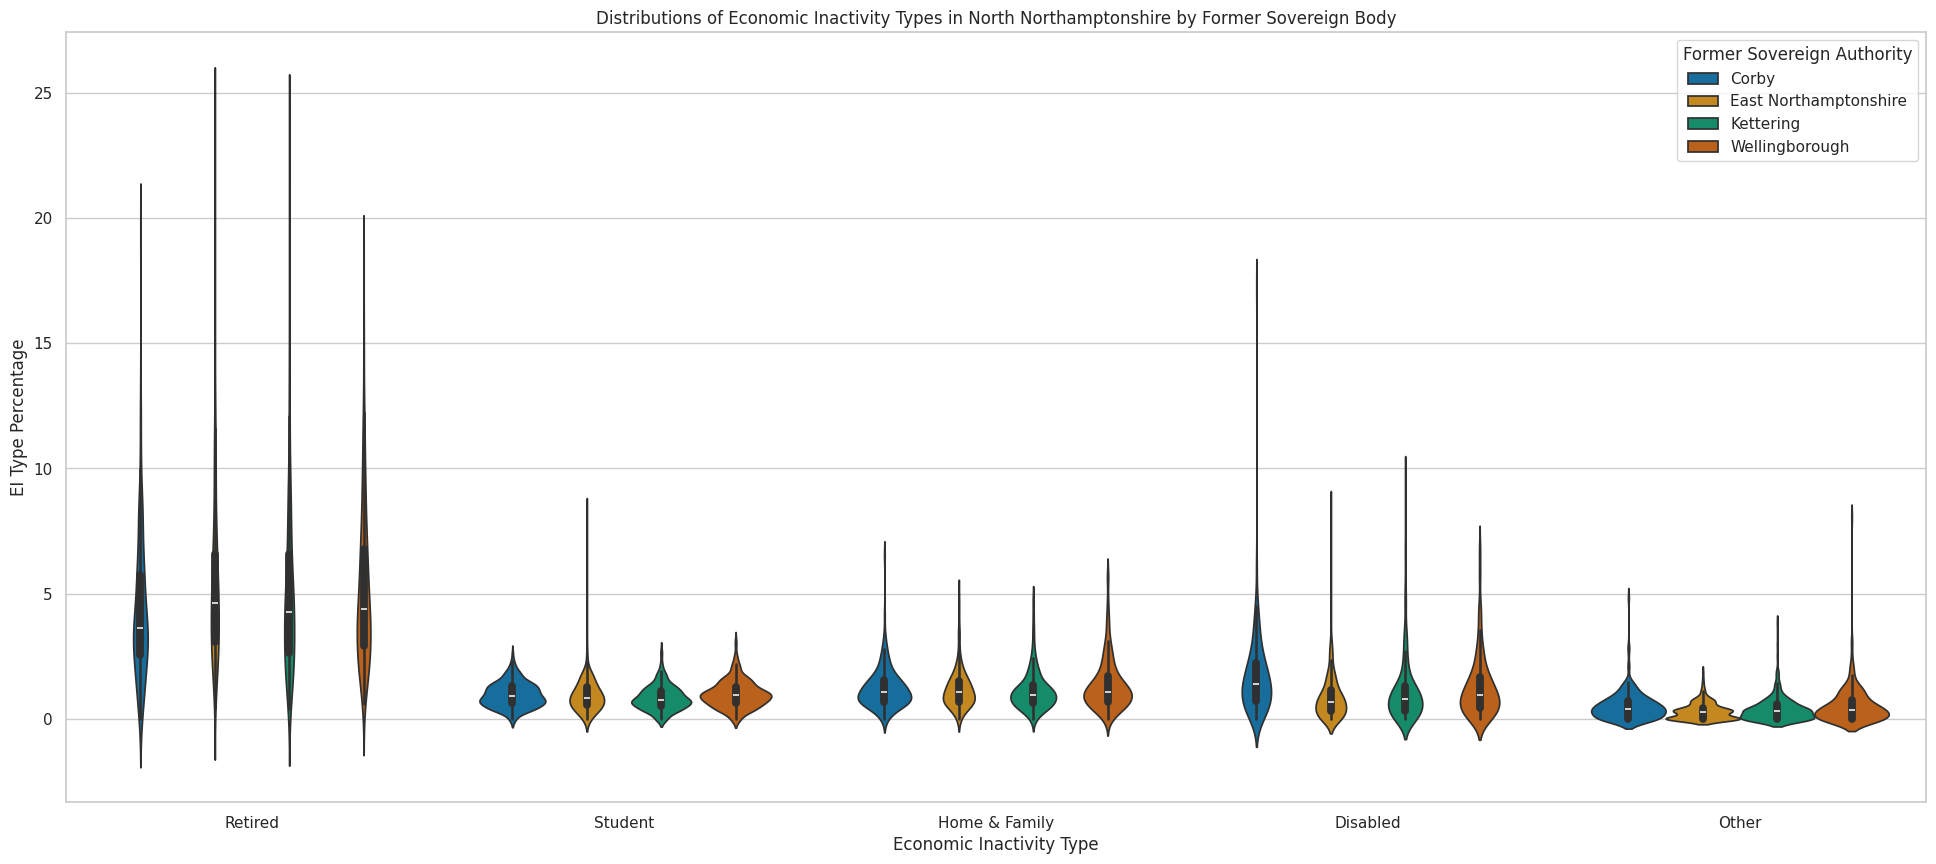

In [5]:
# Data Visualisation
#set figure size as default chart not wide enough, set sns theme
sns.set(rc={"figure.figsize":(24,10)})
sns.set_style('whitegrid')
#create violin plot
ax=sns.violinplot(data=eifinal, x='ei_type', y='pct', hue='subregion', palette='colorblind')
#define chart elements
#set type order for X Axis Ticks
type_order=['Retired', 'Student', 'Home & Family', 'Disabled', 'Other']
ax.set_xticklabels(type_order)
ax.legend(title="Former Sovereign Authority")
ax.set(title='Distributions of Economic Inactivity Types in North Northamptonshire by Former Sovereign Body',
       xlabel='Economic Inactivity Type',
       ylabel='EI Type Percentage');

### Block One Submission
The intention of this visualisation is to explore whether or not there are differences between the distributions of the prevalence different economic inactivity categories in different parts of a local authority area.  

The violin plot was chosen as it is a good way to show the shapes of distributions and compare across categories.

In order to do this it was necessary to use the 'melt' function in Pandas to pivot the data frame allowing the split in the data seen on the plot.

Initially the plot was to be a swarm plot with the hue set by the different economic inactivity categories, however this was abandoned for three reasons; firstly it was very difficult to fit all the sovereign areas on one plot as it wasn't a large enough plot area (it got to the point where it was simply too big). Secondly it was hard to read because of the sheer amount of data, and also for this reason it took a long time to plot.

A violin plot is a more efficient way of demonstrating the same thing (changes in EI type prevalence by area).

The white grid theme was chosen in part for aesthetic reasons, but also because the colours for the palette stood out better compared to the default. The colours for the violin plots themselves were chosen with accessibility in mind. A colourblind friendly palette is a simple way to make the visualisation more accessible

The figure is wide to allow for gaps between the categories.








    

## Block Two Submission:

Using the course notebooks and lectures as a guide create a static visualisation showing the spatial distribution of a variable of your choice. The type of spatial visualisation chosen should be suitable for the data chosen and appropriate data cleaning and pre-processing steps undertaken. Using skills demonstrated in the python notebooks change the default appearance of the visualisation of choice. Include an appropriate title and legend labels. Further marks will be awarded for appropriate use of colour pallets and other customisations to aid interpretation and improve accessibility. Write a brief paragraph in markdown (max 300 words) detailing the visual design choices made.

In [18]:
# import any further required packages
#!pip install contextily
#!pip install geoplot
#!pip install git+https://github.com/pmdscully/geo_northarrow.git
import geopandas as gpd
import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow

In [16]:
# Data-preprocessing
#looking at the violin plot it looks as though the most common type of economic inactivity across all areas is retired
#as we're mapping the most common ei type for each oa we're likely to just get 'retired' on the whole map.
#need to filter the dataset so 'retired' doesn't show up and then return the max for each oa
ei_noret=eiraw.drop(columns=['ei_pct','pct_retired','ei_retired','ei_student','ei_home_fam','ei_disabled','ei_other'])
#create dataframe that has column containing the most prevalent ei type for each row
#define list of columns to check for max
maxcheck=['pct_student', 'pct_home','pct_disabled', 'pct_other']
#create a new dataframe with a column to contain the most prevalent type of economic inactivity for each row
ei_noret['ei_max']=ei_noret[maxcheck].idxmax(axis=1)
ei_noret=pd.DataFrame(ei_noret)
#ei_noret.head()
#ei_noret.info()
#read in oa data and join the ei data using the oa code as the join field
nnc_oa=gpd.read_file('/content/drive/MyDrive/11_census.geojson')
#check crs
#print(nnc_oa.crs)
#nnc_oa.info()
#join data table to oa data
joined=pd.merge(left=nnc_oa, right=ei_noret, left_on='geo_code', right_on='oaCode', how='left').drop(columns=['label', 'name', 'oaCode', 'pop', 'subregion'])
#rename values in ei_max - easy way to get legend labels right
joined['ei_max']=joined['ei_max'].replace({'pct_student': 'Students', 'pct_home': 'Home and Family', 'pct_disabled': 'Disabled People', 'pct_other': 'Other'})
#joined.head()
#joined.info()

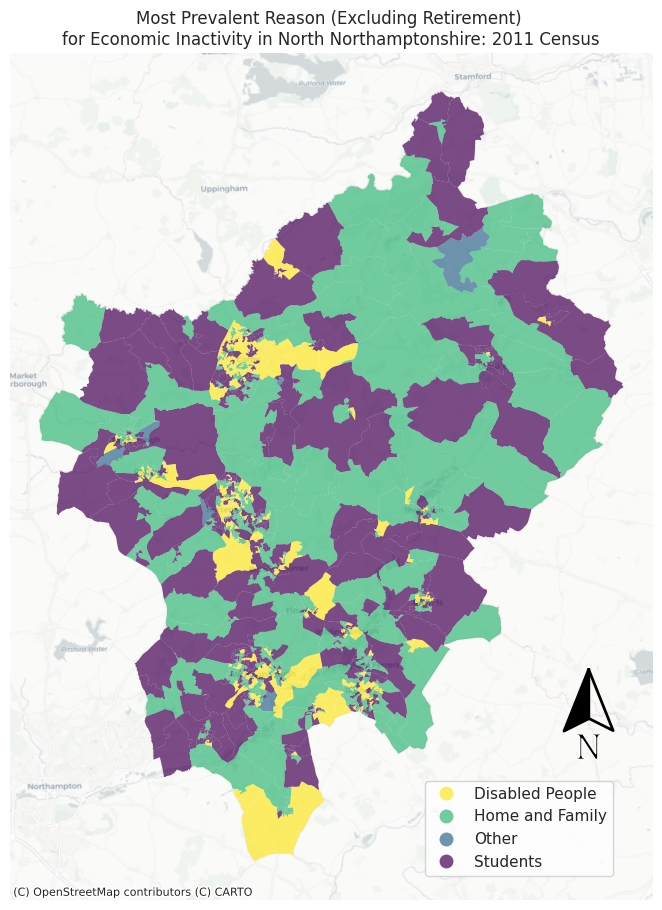

In [32]:
# Data Visualisation
#plot the map using the most common ei type as the symbology
f, ax=plt.subplots(1, figsize=(14,11))
joined.plot(ax=ax, column='ei_max', legend=True, edgecolor='none', cmap='viridis_r', alpha=0.7)
#add legend and set position to bottom right corner
leg=ax.get_legend()
leg.set_bbox_to_anchor((0.95,0.15))
#add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs=joined.crs)
#romove axes, add title
ax.set_axis_off()
ax.set_title('Most Prevalent Reason (Excluding Retirement) \nfor Economic Inactivity in North Northamptonshire: 2011 Census')
#add north arrow
add_north_arrow(ax=ax, scale=.75, xlim_pos=0.9, ylim_pos=.2, color='#000000', text_scaler=3, text_yT=-1.25)
plt.show;

### Block Two Submission
The violin plot showsa that retirees are by far the most common economically inactive population across all four of the areas in the study.

For visualisation on a map, then, it was decided that they would be excluded. Instead the most prevalent class of economically inactive persons was of interest to see if there was a geographic element to this  - interestingly there may be a rural/urban divide to an extent.

To begin, the idxmax populated the 'ei_max' column with the most prevalent EI classification and then the data were joined to the 2011 OAs for the North Northamptonshire area (for ease, this was prepared in QGIS - the layer downloaded did not have a value that contained one of the geographic areas. I am sure it _can_ be done in Pandas)

The colour palette was decided upon as the colours can be distinguished from one another with ease.

The chosen basemap represents a more minimal approach after it was decided that the dark as _too_ dark to really fit with any of the colour schemes tried. The positioning of the legend and north arrow is based purely upon the available space.

One option explored was creating a custom colour mapping for the map as the defaults in combination with the basemaps available were not quite satisfactory. This was eventually abandoned however as the colours were difficult to balance in a way that maximised accessibility and general readability, as well as being aesthetically pleasing.





## Acknowledgements

The use of Gen AI must be acknowledged in an ‘Acknowledgements’ section of any piece of academic work where it has been used as a functional tool to assist in the process of creating academic work.
If it is suspected that you have used a Gen AI tool to produce part of your work, but you have not acknowledged this use, this could be investigated under the Academic Misconduct procedure.
The minimum requirement to include in acknowledgement:
- Name and version of the generative AI system used eg ChatGPT-4.0
- Publisher (company that made the AI system) eg OpenAI
- URL of the AI system
- Brief description (single sentence) of context in which the tool was used.

For example: “I acknowledge the use of ChatGPT-3.5 (Open AI, https://chat.openai.com/) to support development of code to generate legend headings and support formatting of figures”
In the code state:  Prompt: write some python code using the Geopandas package to add a legend title for a colour bar”

For example: “I acknowledge the use of Co-pilot (Microsoft https://chat.openai.com/ Accessed 2025-4-03) to support debugging errors as identified in the code, Prompt: Help debug this error {ERROR MESSAGE} genrated while using the geopandas package”